<a href="https://colab.research.google.com/github/eric565648/0602_lecture/blob/master/hist_filter_range.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histogram Filter 2D localization example

In this simulation, x,y are unknown, yaw is known.
Initial position is not needed.

author: Atsushi Sakai (@Atsushi_twi)
Adapted to Jupyter Notebook by Nick Wang

Switch to Python 3: Runtime -> change runtime type -> Python 3

In [1]:
import copy
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import norm

from IPython.display import display, clear_output

## A. Parameters and Settings

You could switch to different settings.

### A1. RFID Settings - example from Python Robotics 

In [22]:
# Parameters
EXTEND_AREA = 10.0  # [m] grid map extended length
SIM_TIME = 50.0  # simulation time [s]
DT = 0.1  # time tick [s]
MAX_RANGE = 10.0  # maximum observation range
MOTION_STD = 1.0  # standard deviation for motion gaussian distribution
RANGE_STD = 3.0  # standard deviation for observation gaussian distribution

# grid map param
XY_RESOLUTION = 0.5  # xy grid resolution
MIN_X = -15.0
MIN_Y = -5.0
MAX_X = 15.0
MAX_Y = 25.0

# simulation parameters
NOISE_RANGE = 2.0  # [m] 1σ range noise parameter
NOISE_SPEED = 0.5  # [m/s] 1σ speed noise parameter

show_animation = True

# RF_ID positions [x, y]
RF_ID = np.array([[10.0, 0.0],
                  [10.0, 10.0],
                  [0.0, 15.0],
                  [-5.0, 20.0]])

### A2. Vitural Trail Settings

In [23]:
# Parameters
EXTEND_AREA = 10.0  # [m] grid map extended length
SIM_TIME = 50.0  # simulation time [s]
DT = 0.1  # time tick [s]
#MAX_RANGE = 10.0  # maximum observation range
MAX_RANGE = 25.0  # maximum observation range
MOTION_STD = 1.0  # standard deviation for motion gaussian distribution
RANGE_STD = 1.0  # standard deviation for observation gaussian distribution

# grid map param
XY_RESOLUTION = 1  # xy grid resolution
MIN_X = -25.0
MIN_Y = -15.0
MAX_X = 25.0
MAX_Y = 35.0

# simulation parameters
NOISE_RANGE = 1.0  # [m] 1σ range noise parameter
NOISE_SPEED = 0.5  # [m/s] 1σ speed noise parameter

show_animation = True

RF_ID = np.array([[10.0, 0.0],
                  [10.0, 1.0],
                  [9.0, 0.0],
                  [9.0, 1.0]])

### A3. SBL-UWB Settings

In [24]:
anchors = np.array([[10.0, 0.0],
                  [10.0, 1.0],
                  [9.0, 0.0],
                  [9.0, 1.0]])

## B. Velocity Motion Model

The robot will have constant linear and angular velocity and do a circling with radius 10.


### B1. Circling

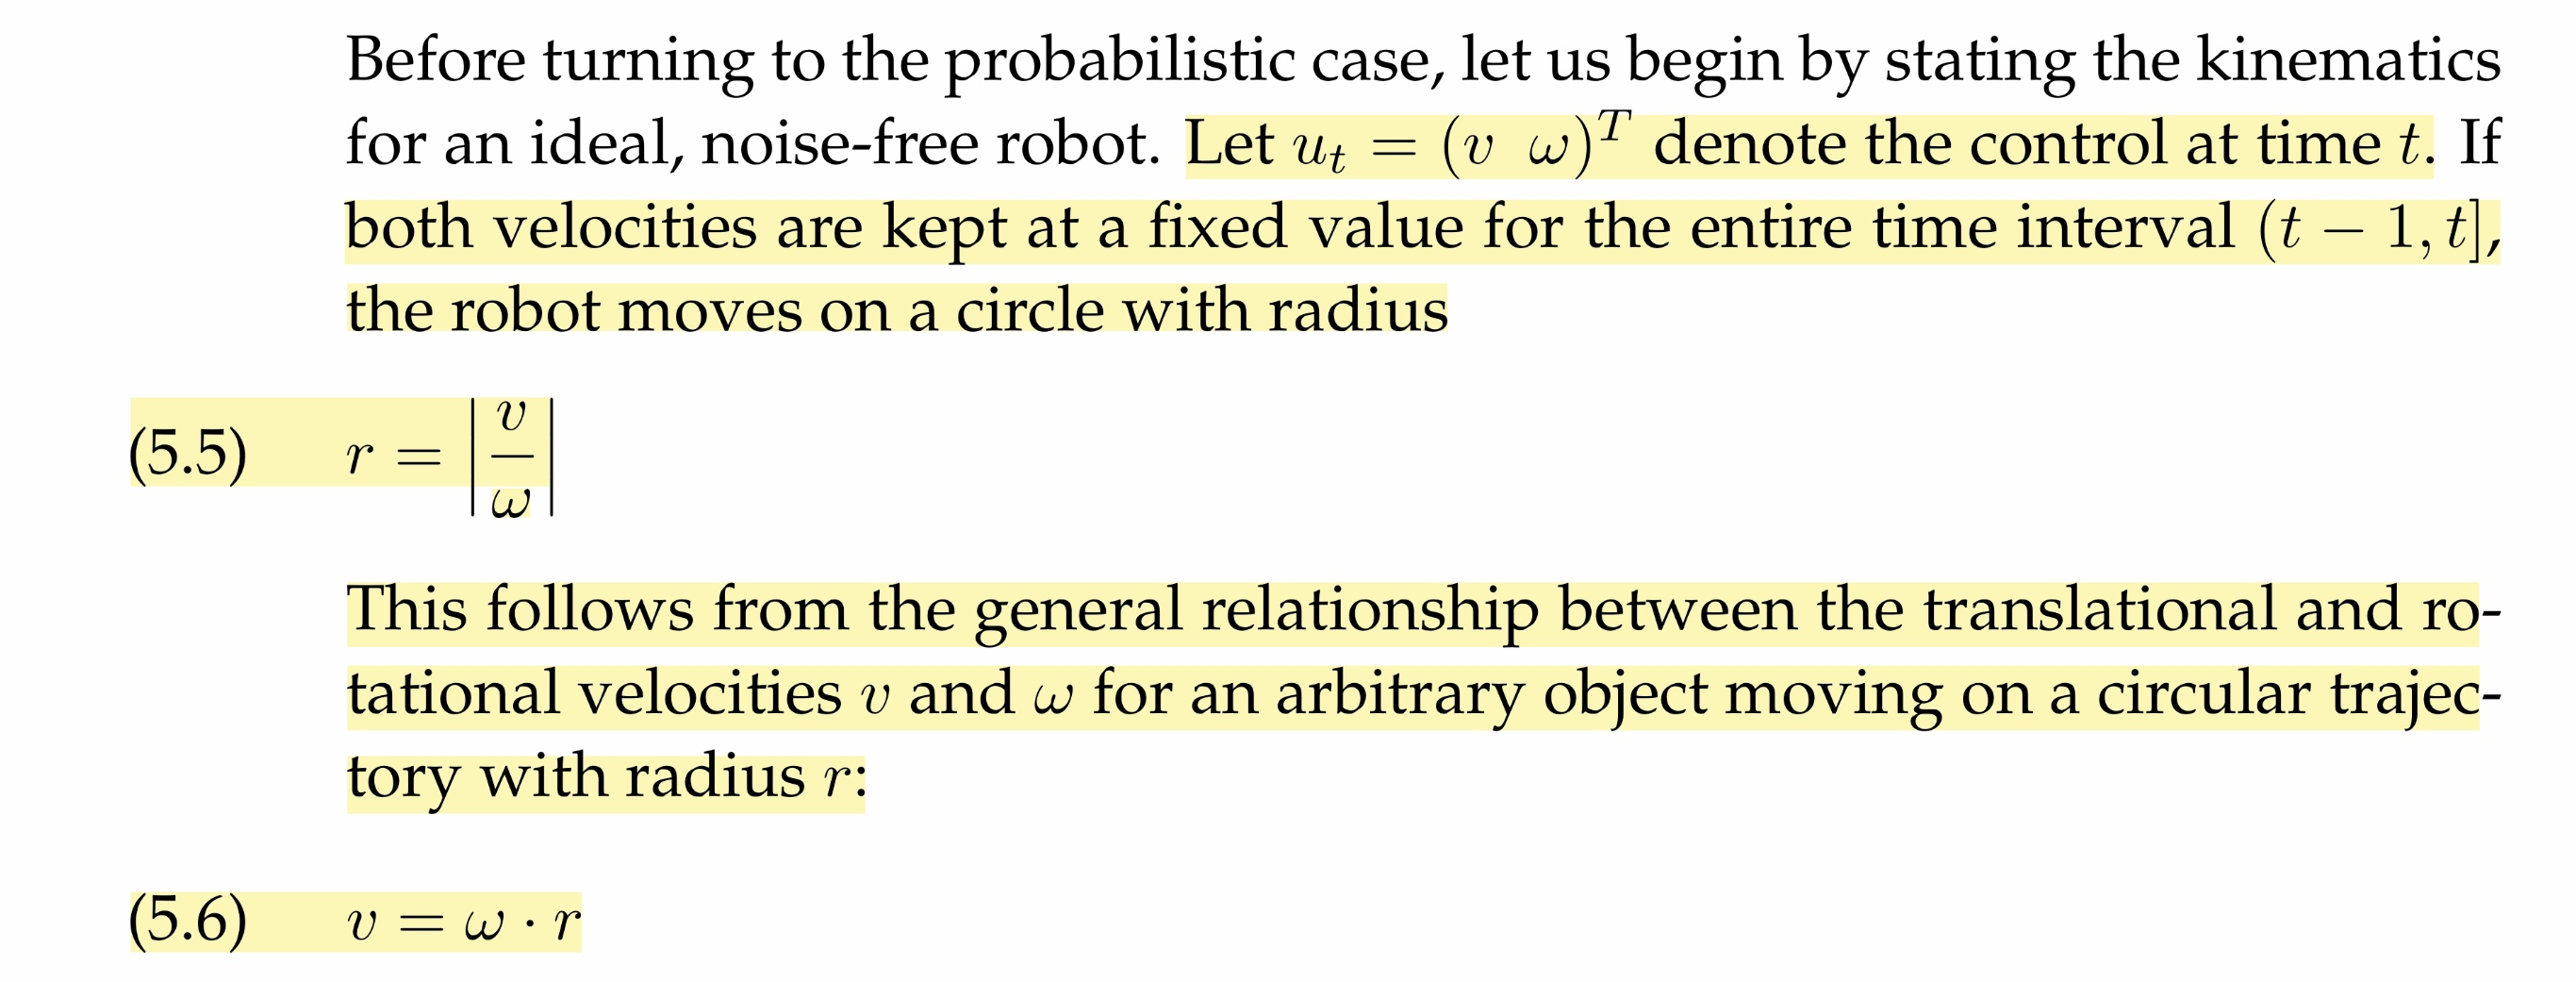

In [25]:
def calc_input():
    v = 1.0  # [m/s]
    yaw_rate = 0.1  # [rad/s]
    u = np.array([v, yaw_rate]).reshape(2, 1)
    return u


### B2. Follow Each Anchor

## C. Histogram Filter Localization

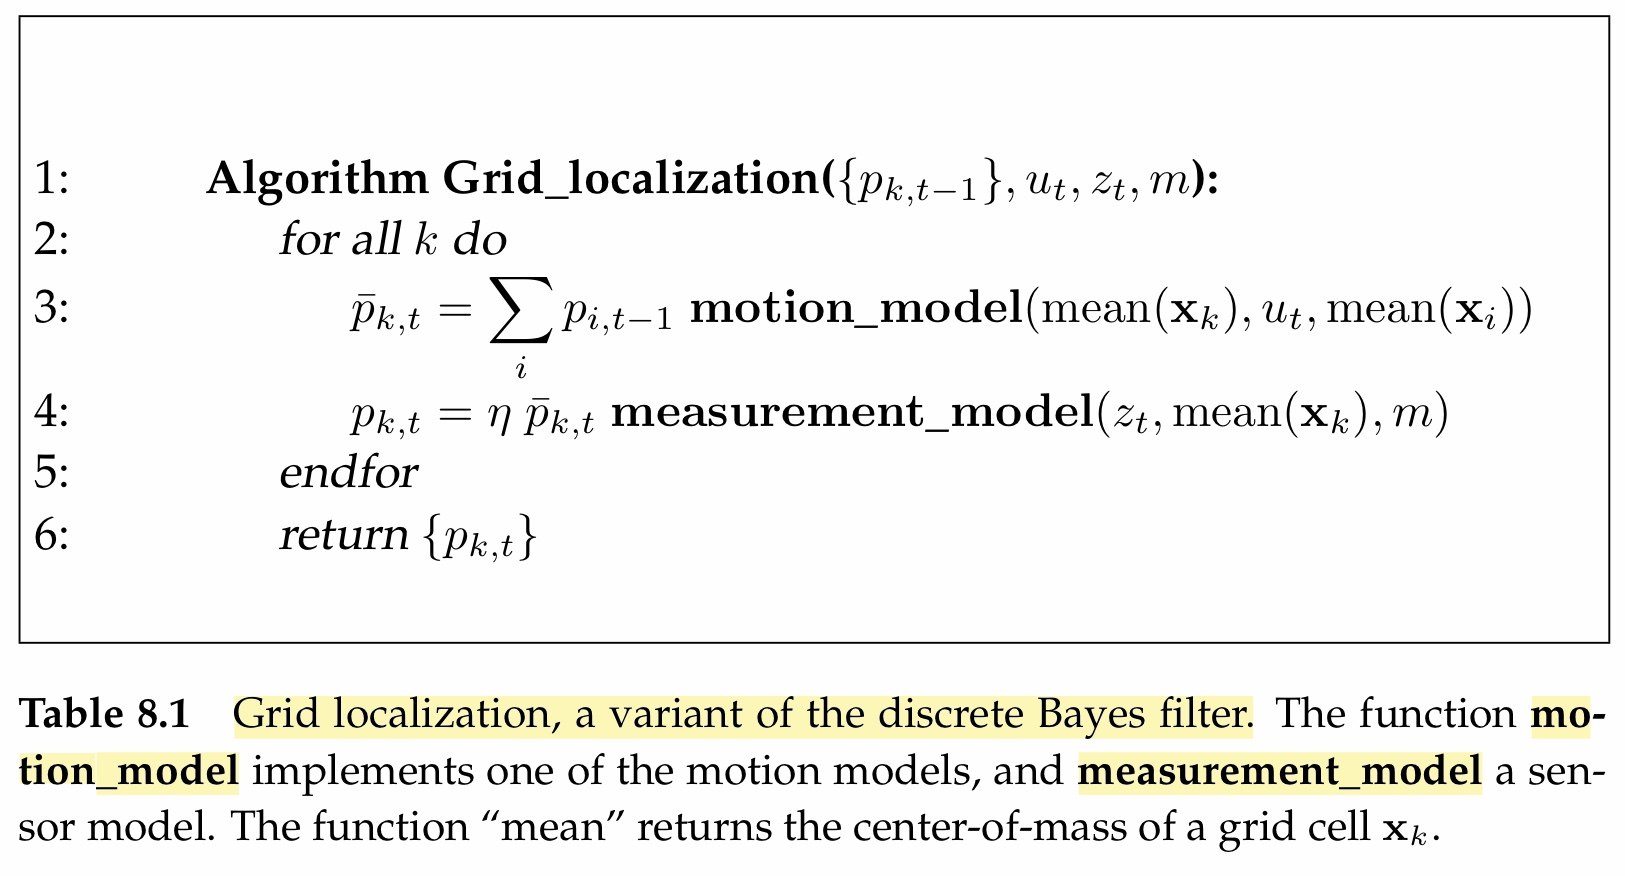

---



### C1. GridMap

In [26]:
class GridMap:

    def __init__(self):
        self.data = None
        self.xy_resolution = None
        self.min_x = None
        self.min_y = None
        self.max_x = None
        self.max_y = None
        self.x_w = None
        self.y_w = None
        self.dx = 0.0  # movement distance
        self.dy = 0.0  # movement distance

def histogram_filter_localization(grid_map, u, z, yaw):
    grid_map = motion_update(grid_map, u, yaw)

    grid_map = observation_update(grid_map, z, RANGE_STD)

    return grid_map

def normalize_probability(grid_map):
    sump = sum([sum(i_data) for i_data in grid_map.data])

    for ix in range(grid_map.x_w):
        for iy in range(grid_map.y_w):
            grid_map.data[ix][iy] /= sump

    return grid_map


def init_grid_map(xy_resolution, min_x, min_y, max_x, max_y):
    grid_map = GridMap()

    grid_map.xy_resolution = xy_resolution
    grid_map.min_x = min_x
    grid_map.min_y = min_y
    grid_map.max_x = max_x
    grid_map.max_y = max_y
    grid_map.x_w = int(round((grid_map.max_x - grid_map.min_x)
                             / grid_map.xy_resolution))
    grid_map.y_w = int(round((grid_map.max_y - grid_map.min_y)
                             / grid_map.xy_resolution))

    grid_map.data = [[1.0 for _ in range(grid_map.y_w)]
                     for _ in range(grid_map.x_w)]
    grid_map = normalize_probability(grid_map)

    return grid_map


def map_shift(grid_map, x_shift, y_shift):
    tmp_grid_map = copy.deepcopy(grid_map.data)

    for ix in range(grid_map.x_w):
        for iy in range(grid_map.y_w):
            nix = ix + x_shift
            niy = iy + y_shift

            if 0 <= nix < grid_map.x_w and 0 <= niy < grid_map.y_w:
                grid_map.data[ix + x_shift][iy + y_shift] =\
                    tmp_grid_map[ix][iy]

    return grid_map



### C2. Motion Model

In [27]:
def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = np.dot(F, x) + np.dot(B, u)

    return x


def motion_update(grid_map, u, yaw):
    grid_map.dx += DT * math.cos(yaw) * u[0]
    grid_map.dy += DT * math.sin(yaw) * u[0]

    x_shift = grid_map.dx // grid_map.xy_resolution
    y_shift = grid_map.dy // grid_map.xy_resolution

    if abs(x_shift) >= 1.0 or abs(y_shift) >= 1.0:  # map should be shifted
        grid_map = map_shift(grid_map, int(x_shift), int(y_shift))
        grid_map.dx -= x_shift * grid_map.xy_resolution
        grid_map.dy -= y_shift * grid_map.xy_resolution

    grid_map.data = gaussian_filter(grid_map.data, sigma=MOTION_STD)

    return grid_map


### C3. Measurement Model

In [28]:
def calc_gaussian_observation_pdf(grid_map, z, iz, ix, iy, std):
    # predicted range
    x = ix * grid_map.xy_resolution + grid_map.min_x
    y = iy * grid_map.xy_resolution + grid_map.min_y
    d = math.hypot(x - z[iz, 1], y - z[iz, 2])

    # likelihood
    pdf = (1.0 - norm.cdf(abs(d - z[iz, 0]), 0.0, std))

    return pdf


def observation_update(grid_map, z, std):
    for iz in range(z.shape[0]):
        for ix in range(grid_map.x_w):
            for iy in range(grid_map.y_w):
                grid_map.data[ix][iy] *= calc_gaussian_observation_pdf(
                    grid_map, z, iz, ix, iy, std)

    grid_map = normalize_probability(grid_map)

    return grid_map



def observation(xTrue, u, RFID):
    xTrue = motion_model(xTrue, u)

    z = np.zeros((0, 3))

    for i in range(len(RFID[:, 0])):

        dx = xTrue[0, 0] - RFID[i, 0]
        dy = xTrue[1, 0] - RFID[i, 1]
        d = math.hypot(dx, dy)
        if d <= MAX_RANGE:
            # add noise to range observation
            dn = d + np.random.randn() * NOISE_RANGE
            zi = np.array([dn, RFID[i, 0], RFID[i, 1]])
            z = np.vstack((z, zi))

    # add noise to speed
    ud = u[:, :]
    ud[0] += np.random.randn() * NOISE_SPEED

    return xTrue, z, ud

## D. Visualization

In [29]:
def draw_heat_map(data, mx, my):
    max_value = max([max(i_data) for i_data in data])
    plt.pcolor(mx, my, data, vmax=max_value, cmap=plt.cm.get_cmap("Blues"))
    plt.axis("equal")

def calc_grid_index(grid_map):
    mx, my = np.mgrid[slice(grid_map.min_x - grid_map.xy_resolution / 2.0,
                            grid_map.max_x + grid_map.xy_resolution / 2.0,
                            grid_map.xy_resolution),
                      slice(grid_map.min_y - grid_map.xy_resolution / 2.0,
                            grid_map.max_y + grid_map.xy_resolution / 2.0,
                            grid_map.xy_resolution)]

    return mx, my

## E. Tasks


### E1. Baseline.

Navigation (circling) with 4 anchors known positions

In [30]:
time = 0.0

xTrue = np.zeros((4, 1))

grid_map = init_grid_map(XY_RESOLUTION, MIN_X, MIN_Y, MAX_X, MAX_Y)
mx, my = calc_grid_index(grid_map)  # for grid map visualization


## Loop
while SIM_TIME >= time:
  time += DT

  u = calc_input()
  yaw = xTrue[2, 0]  # Orientation is known
  xTrue, z, ud = observation(xTrue, u, RF_ID)
  grid_map = histogram_filter_localization(grid_map, u, z, yaw)

  plt.cla()
  # for stopping simulation with the esc key.
  # plt.gcf().canvas.mpl_connect(
  #    'key_release_event',
  #    lambda event: [exit(0) if event.key == 'escape' else None])
  draw_heat_map(grid_map.data, mx, my)
  plt.plot(xTrue[0, :], xTrue[1, :], "xr")
  plt.plot(RF_ID[:, 0], RF_ID[:, 1], ".k")
  for i in range(z.shape[0]):
      plt.plot([xTrue[0, :], z[i, 1]], [
      xTrue[1, :], z[i, 2]], "-k")
      plt.title("Time[s]:" + str(time)[0: 4])
  plt.title("Time[s]:" + str(time)[0: 4])


  plt.show()
  clear_output(wait = True)

  plt.pause(0.001)

KeyboardInterrupt: ignored

# SBL-UWB Exp1

## V-SLAM v.s. SBL-UWB

We analyze Orbslam2 results with SBL-UWB

## Round Data

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/subt-colab/10-hist-filter-range")
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/.shortcut-targets-by-id/1FZS4lp9BL1RjFg4ueXu7jEZ1iBlaWGda/subt-colab/10-hist-filter-range'

Each round data contain 2d position and timestamp
We set 5 groundtruth artifacts in the environment.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.markers as markers
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
import seaborn as sns; sns.set()
import numpy as np
import math
import copy
import yaml
import sys

import sklearn
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
# from mpl_toolkits import mplot3d
# from points_registration import points_registration

import copy
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import norm

from IPython.display import display, clear_output

### Draw Definition

In [ ]:
color_met = {'vo': [1, 1, 0], 'ekf': [0, 1, 0], 'sbl': [1, 0, 1], 'gt': [0, 1, 1]}
vo_patch = Line2D([0], [0], marker='.', color='w', label='ORB-SLAM', markerfacecolor=color_met['vo'], markersize=35)
sbl_patch = Line2D([0], [0], marker='.', color='w', label='SBL-UWB', markerfacecolor=color_met['sbl'], markersize=35)
ekf_patch = Line2D([0], [0], marker='.', color='w', label='SBL-UWB EKF', markerfacecolor=color_met['ekf'], markersize=35)
gt_patch = Line2D([0], [0], marker='.', color='w', label='Way Points', markerfacecolor=color_met['gt'], markersize=35)
patches = [sbl_patch, ekf_patch, vo_patch, gt_patch]

def ax_init(ax):
    ax.set_facecolor((0.0, 0.0, 0.0))
    # axes[0].axis('equal')
    ax.set_aspect('auto')
    ax.set_xbound(lower=-15, upper=15)
    ax.set_ybound(lower=-10, upper=25)
    ax.set_xticks(ticks=ax.get_xticks())
    ax.set_xticklabels(-1*ax.get_xticks())
    ax.tick_params(axis='both',labelsize=30)
    ax.legend(handles=patches, fontsize=30)
    ax.set_xlabel('Scout Robot Position Y (meter)', fontsize=30)
    ax.set_ylabel('Scout Robot Position X (meter)', fontsize=30)
    return ax

gt_pose = {'drill_l':[4.8, 10], 'extinguisher':[10.4, 7.6], 'survivor':[14.8, 0], 'drill_r':[4.8, -10], 'backpack':[10.4, -7.6]}
gt_pose_arr = np.array([[-5.7, 0], [4.8, 10], [10.4, 7.6], [14.8, 0], [10.4, -7.6], [4.8, -10], [-5.7, 0]])

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
ang_color = prop_cycle.by_key()['color']
# ang_color = ['red', 'blue', 'black', 'white', 'green', 'yellow', 'pink', 'magenta', 'gray']
patch_20 = Line2D([0], [0], marker='.', color=ang_color[0], label='0.2*0.2 (meter)', markerfacecolor=ang_color[0], markersize=15)
patch_30 = Line2D([0], [0], marker='.', color=ang_color[1], label='0.3*0.3', markerfacecolor=ang_color[1], markersize=15)
patch_40 = Line2D([0], [0], marker='.', color=ang_color[2], label='0.4*0.4', markerfacecolor=ang_color[2], markersize=15)
patch_60 = Line2D([0], [0], marker='.', color=ang_color[3], label='0.6*0.6', markerfacecolor=ang_color[3], markersize=15)
patch_90 = Line2D([0], [0], marker='.', color=ang_color[4], label='0.9*0.9', markerfacecolor=ang_color[4], markersize=15)
patch_120 = Line2D([0], [0], marker='.', color=ang_color[5], label='1.2*1.2', markerfacecolor=ang_color[5], markersize=15)
patch_h2 = Line2D([0], [0], marker='.', color=ang_color[6], label='robot (0.6*0.4)', markerfacecolor=ang_color[6], markersize=15)
patch_hs2 = Line2D([0], [0], marker='.', color=ang_color[7], label='husky2_s', markerfacecolor=ang_color[7], markersize=15)
patch_hs1 = Line2D([0], [0], marker='.', color=ang_color[8], label='husky1_s', markerfacecolor=ang_color[8], markersize=15)
patches_ang = [patch_20, patch_30, patch_40, patch_60, patch_90, patch_120, patch_h2]

plt.figure(figsize=(9, 7.5))

# skip = [20, 30, 40, 60, 90, 120, 'husky2_h', 'husky2_hs', 'husky1_hs']
# skip = np.array([20, 30, 40, 60, 90, 120])
# skip = ['husky2_h', 'husky2_hs']
# skip = [20, 30,90,120]
skip = ['husky2_hs', 'husky1_hs']
count = 0
for size in size_type:
    e_mean = []
    e_deviation = []
    samples = []
    maxes = []
    mins = []
    for dist in dist_type:
        e_mean = np.append(e_mean, np.mean(anchor_rmse[size][dist]))
        e_deviation = np.append(e_deviation, np.std(anchor_rmse[size][dist]))
        samples = np.append(samples, all_samples[size][dist])
        maxes = np.append(maxes, max_error[size][dist])
        mins = np.append(mins, min_error[size][dist])
    print e_mean
    #print e_deviation
    #print samples
    #print maxes
    #print mins
    if size not in skip:
        plt.ylim(top=8)
        plt.rc('xtick',labelsize='x-large')
        plt.rc('ytick',labelsize='x-large')
        plt.ylabel("Error (Mean, Std), Meter", fontsize='xx-large')
        plt.xlabel("Localized Tag Distance, Meter", fontsize='xx-large')
        plt.legend(handles=patches_ang, fontsize='x-large')
        plt.errorbar(dist_type, e_mean, e_deviation, linestyle='-', marker='.', color=ang_color[count], mec=ang_color[count], mfc=ang_color[count], mew=2)
    #plt.plot(dist_array, samples, '.-', mew=4)
    #plt.plot(dist_array, maxes, '.-', mew=4)
    #plt.plot(dist_array, mins, '.-', mew=4)
    #ang_dots[angle]
    count += 1
plt.figure(figsize=(9, 7.5))
plt.show()

## Histogram filter on round data

In [3]:
# Parameters
#EXTEND_AREA = 10.0  # [m] grid map extended length
#SIM_TIME = 50.0  # simulation time [s]
#DT = 0.1  # time tick [s]
#MAX_RANGE = 25.0  # maximum observation range
MOTION_STD = 1.0  # standard deviation for motion gaussian distribution
RANGE_STD = 1.0  # standard deviation for observation gaussian distribution

# grid map param
XY_RESOLUTION = 1  # xy grid resolution
MIN_X = -7.0
MIN_Y = -12.0
MAX_X = 18.0
MAX_Y = 12.0

# simulation parameters
#NOISE_RANGE = 1.0  # [m] 1σ range noise parameter
#NOISE_SPEED = 0.5  # [m/s] 1σ speed noise parameter

#show_animation = True

anchor_position = np.array([[0.0301, 0.3085],
                  [0.0301, -0.3085],
                  [0.3857, 0.2739],
                  [0.3857, -0.2739]]) ## on husky
anc = {'back_left': [0.0301, 0.3085], 'back_right': [0.0301, -0.3085], 'front_left': [0.3857, 0.2739], 'front_right': [0.3857, -0.2739]}

In [4]:
class GridMap:

    def __init__(self):
        self.data = None
        self.xy_resolution = None
        self.min_x = None
        self.min_y = None
        self.max_x = None
        self.max_y = None
        self.x_w = None
        self.y_w = None
        self.dx = 0.0  # movement distance
        self.dy = 0.0  # movement distance

def histogram_filter_localization(grid_map, u, z, yaw):
    grid_map = motion_update(grid_map, u, yaw)

    grid_map = observation_update(grid_map, z, RANGE_STD)

    return grid_map

def normalize_probability(grid_map):
    sump = sum([sum(i_data) for i_data in grid_map.data])

    for ix in range(grid_map.x_w):
        for iy in range(grid_map.y_w):
            grid_map.data[ix][iy] /= sump

    return grid_map


def init_grid_map(xy_resolution, min_x, min_y, max_x, max_y, initial_guess=None):
    grid_map = GridMap()

    grid_map.xy_resolution = xy_resolution
    grid_map.min_x = min_x
    grid_map.min_y = min_y
    grid_map.max_x = max_x
    grid_map.max_y = max_y
    grid_map.x_w = int(round((grid_map.max_x - grid_map.min_x)
                             / grid_map.xy_resolution))
    grid_map.y_w = int(round((grid_map.max_y - grid_map.min_y)
                             / grid_map.xy_resolution))

    if initial_guess is None:
        grid_map.data = [[1.0 for _ in range(grid_map.y_w)]
                     for _ in range(grid_map.x_w)]
        grid_map = normalize_probability(grid_map)
    else:
        grid_map.data = [[0.0 for _ in range(grid_map.y_w)]
                     for _ in range(grid_map.x_w)]

        init_x = initial_guess[0, 0]
        init_y = initial_guess[1, 0]
        grid_x = int((init_x - grid_map.min_x)
                             / grid_map.xy_resolution)
        grid_y = int((init_y - grid_map.min_y)
                             / grid_map.xy_resolution)
        
        grid_map.data[grid_x][grid_y] = 1.0
        grid_map.dx = init_x - (grid_x*grid_map.xy_resolution + grid_map.min_x)
        grid_map.dy = init_y - (grid_y*grid_map.xy_resolution + grid_map.min_y)

    return grid_map


def map_shift(grid_map, x_shift, y_shift):
    tmp_grid_map = copy.deepcopy(grid_map.data)

    for ix in range(grid_map.x_w):
        for iy in range(grid_map.y_w):
            nix = ix + x_shift
            niy = iy + y_shift

            if 0 <= nix < grid_map.x_w and 0 <= niy < grid_map.y_w:
                grid_map.data[ix + x_shift][iy + y_shift] =\
                    tmp_grid_map[ix][iy]

    return grid_map


In [5]:
def motion_model(x, u):
    #F = np.array([[1.0, 0, 0, 0],
    #              [0, 1.0, 0, 0],
    #              [0, 0, 1.0, 0],
    #              [0, 0, 0, 0]])

    #B = np.array([[DT * math.cos(x[2, 0]), 0],
    #              [DT * math.sin(x[2, 0]), 0],
    #              [0.0, DT],
    #              [1.0, 0.0]])
    
    # motion model for wheel odometry
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0]])
    B = np.array([[1.0, 0.0, 0.0],
                  [0.0, 1.0, 0.0],
                  [0.0, 0.0, 1.0]])

    x = np.dot(F, x) + np.dot(B, u)

    return x


def motion_update(grid_map, u, yaw):
    #grid_map.dx += DT * math.cos(yaw) * u[0]
    #grid_map.dy += DT * math.sin(yaw) * u[0]
    grid_map.dx += u[0]
    grid_map.dy += u[1]

    x_shift = grid_map.dx // grid_map.xy_resolution
    y_shift = grid_map.dy // grid_map.xy_resolution

    if abs(x_shift) >= 1.0 or abs(y_shift) >= 1.0:  # map should be shifted
        grid_map = map_shift(grid_map, int(x_shift), int(y_shift))
        grid_map.dx -= x_shift * grid_map.xy_resolution
        grid_map.dy -= y_shift * grid_map.xy_resolution

    grid_map.data = gaussian_filter(grid_map.data, sigma=MOTION_STD)
    #print(grid_map.data)

    return grid_map


In [6]:
def calc_gaussian_observation_pdf(grid_map, z, iz, ix, iy, std):
    # predicted range
    x = ix * grid_map.xy_resolution + grid_map.min_x
    y = iy * grid_map.xy_resolution + grid_map.min_y
    d = math.hypot(x - z[iz, 1], y - z[iz, 2])

    # likelihood
    pdf = (1.0 - norm.cdf(abs(d - z[iz, 0]), 0.0, std))

    return pdf


def observation_update(grid_map, z, std):
    for iz in range(z.shape[0]):
        for ix in range(grid_map.x_w):
            for iy in range(grid_map.y_w):
                grid_map.data[ix][iy] *= calc_gaussian_observation_pdf(
                    grid_map, z, iz, ix, iy, std)

    grid_map = normalize_probability(grid_map)

    return grid_map



def observation(xTrue, u, anchor_position):
    xTrue = motion_model(xTrue, u)

    #z = np.zeros((0, 3))

    #for i in range(len(anchor_position[:, 0])):

    #    dx = xTrue[0, 0] - anchor_position[i, 0]
    #    dy = xTrue[1, 0] - anchor_position[i, 1]
    #    d = math.hypot(dx, dy)
    #    if d <= MAX_RANGE:
            # add noise to range observation
    #        dn = d + np.random.randn() * NOISE_RANGE
    #        zi = np.array([dn, anchor_position[i, 0], anchor_position[i, 1]])
    #        z = np.vstack((z, zi))

    # add noise to speed
    #ud = u[:, :]
    #ud[0] += np.random.randn() * NOISE_SPEED

    return xTrue

In [ ]:
step = 0
irange = 0

#xTrue = np.zeros((4, 1))
# initial pose
xTrack = np.array([[-5.71], [0], [0]])
grid_map = init_grid_map(XY_RESOLUTION, MIN_X, MIN_Y, MAX_X, MAX_Y, xTrack)
# mx, my = calc_grid_index(grid_map)  # for grid map visualization

## read range data
filename = './data/husky2_allb_clockwise_range.yaml'
with open(filename) as r_file:
    all_data = yaml.load(r_file)
    r_data = all_data['data']
    r_data_stamp = all_data['timestamp']
    h_start_t = all_data['start_time']['secs'] + all_data['start_time']['nsecs'] * 1e-9
## read wheel odom data
filename = './data/wheel/locobot27_allb_clockwise_wheel.yaml'
with open(filename) as w_file:
    all_data = yaml.load(w_file)
    w_data = all_data['data']
    l_start_t = all_data['start_time']['secs'] + all_data['start_time']['nsecs'] * 1e-9

TOTAL_STEP = len(w_data['timestamp'])
T_OFFSET = h_start_t - l_start_t

wst = w_data['timestamp'][0]
while True:
    rt = r_data_stamp[27175][irange] + T_OFFSET
    if rt >= wst:
        break
    irange += 1
irange -= 1

## Loop
while TOTAL_STEP >= step:

    yaw = xTrack[2, 0]  # Orientation is known
    # xTrue = observation(xTrue, u, anchor_position)
    # z = [[d, anchor_x, anchor_y], ...]
  
    # get motion input
    #u = calc_input()
    u = np.array([[w_data['x'][step]], [w_data['y'][step]], [w_data['yaw'][step]]])
    # get observation
    z = np.array([])
    r_stamp = r_data_stamp[27175][irange] + T_OFFSET
    
    if w_data['timestamp'][step] >= r_stamp:
        for pos in r_data:
            if r_data[pos][27175][irange] == 0:
                continue
            if len(z) == 0:
                z = np.array([[r_data[pos][27175][irange]/1000., anc[pos][0], anc[pos][1]]])
            else:
                z = np.vstack((z, np.array([r_data[pos][27175][irange]/1000., anc[pos][0], anc[pos][1]])))
        irange += 1

    grid_map = histogram_filter_localization(grid_map, u, z, yaw)
    #print(grid_map.data)
    #print(np.argmax(grid_map.data))
    gmax = np.unravel_index(np.argmax(grid_map.data), np.array(grid_map.data).shape)
    print(gmax)
    #print(grid_map.data)
    xTrack = np.array([[grid_map.min_x + gmax[0]*XY_RESOLUTION],[grid_map.min_y + gmax[1]*XY_RESOLUTION], [yaw+u[2, 0]]])
    print(xTrack)

    # plt.cla()
    # for stopping simulation with the esc key.
    # plt.gcf().canvas.mpl_connect(
    #    'key_release_event',
    #    lambda event: [exit(0) if event.key == 'escape' else None])
    # draw_heat_map(grid_map.data, mx, my)
    # plt.plot(xTrue[0, :], xTrue[1, :], "xr")
    # plt.plot(RF_ID[:, 0], RF_ID[:, 1], ".k")
    #for i in range(z.shape[0]):
        #plt.plot([xTrue[0, :], z[i, 1]], [
        #xTrue[1, :], z[i, 2]], "-k")
        #plt.title("Time[s]:" + str(time)[0: 4])
    #plt.title("Time[s]:" + str(time)[0: 4])


    #plt.show()
    #clear_output(wait = True)

    #plt.pause(0.001)

    step += 1

Streaming output truncated to the last 5000 lines.
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19779226]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19796679]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19709412]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19534879]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19307987]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19290533]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19290533]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19290533]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19726866]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19709412]]
(2, 14)
[[-5.        ]
 [ 2.        ]
 [-3.19447613]]
(2, 14)
[[-5.      ]
 [ 2.      ]
 [-3.193778]]
(3, 16)
[[-4.        ]
 [ 4.        ]
 [-3.19290533]]
(2, 15)
[[-5.        ]
 [ 3.        ]
 [-3.19255627]]
(2, 15)
[[-5.        ]
 [ 3.        ]
 [-3.19185814]]
(3, 16)
[[-4.        ]
 [ 4.        ]
 [-3.19098547]]
(2, 15)
[[-5.        ]
 [ 3.        ]
 [-3.18906561]]
(2, 14)
[[-5.        ]
 [ 2.        ]

## EKF SBL-UWB + Wheel Odometry

It's similar to wheel odom + gps.

In [ ]:
def motion_predict(x_t, dx, dy, dyaw, p_t):
    
    # noise of motion prediction
    Q = np.diag([
    0.01,  # variance of location on x-axis
    0.01,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    ]) ** 2  # predict state covariance
    
    u = np.array([[dx], [dy], [dyaw]])
    x_pred = motion_model(x_t, u)
    jF = jacob_f(x_t, u)
    p_pred = np.matmul(np.matmul(jF,p_t),np.transpose(jF)) + Q
    
    return x_pred, p_pred

In [ ]:
def observation(x_pred, obs_mode):

    if obs_mode == 'xy':
        H = np.array([
            [1, 0, 0],
            [0, 1, 0]
        ])
        z = np.matmul(H,x_pred)
    elif obs_mode == 'rt':
        r = math.sqrt(x_pred[0,0]**2 + x_pred[1,0]**2)
        theta = math.atan2(x_pred[1,0],x_pred[0,0])
        z = np.array([[r],[theta]])
    else:
        z = np.array([[np.nan],[np.nan]])

    return z

In [ ]:
def motion_model(x, u):
    F = np.array([[1.0, 0, 0],
                  [0, 1.0, 0],
                  [0, 0, 1.0]])

    # We have input respect to xt
    # Remeber to transform to be respect to map
    B = np.array([[math.cos(x[2]), 0, 0],
                  [math.sin(x[2]), 0, 0],
                  [0.0, 0.0, 1.0]])

    x_pred = np.matmul(F,x) + np.matmul(B,u)

    return x_pred

In [ ]:
def jacob_f(x, u):
    """
    Jacobian of Motion Model
    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    #yaw = x[2, 0]
    #v = u[0, 0]
    #jF = np.array([
    #    [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
    #    [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
    #    [0.0, 0.0, 1.0, 0.0],
    #    [0.0, 0.0, 0.0, 1.0]])
    
    """
    G 
    """
    yaw = x[2,0]
    dx = u[0,0]
    dyaw = u[2,0]
    jF = np.array([
        [1.0, 0.0, -1*dx*math.sin(yaw)],
        [0.0, 1.0, dx*math.cos(yaw)],
        [0.0, 0.0, 1.0]])

    return jF

In [ ]:
def jacob_h(obs_mode, z_t):
    # Jacobian of Observation Model
    
    if obs_mode == 'xy':
        jH = np.array([
            [1, 0, 0],
            [0, 1, 0]
        ])
    elif obs_mode == 'rt':
        x = z_t[0, 0]
        y = z_t[1, 0]
        r2 = x**2+y**2
        r = math.sqrt(r2)
        jH = np.array([
            [x/r, y/r, 0],
            [-1*y/r2, x/r2, 0]
        ])
        
    return jH

In [ ]:
def ekf_estimation(p_pred, x_pred, y, k_gain_use, obs_mode, z_t):
    
    if obs_mode == 'xy':
        # Observation x,y position covariance
        R = np.diag([5, 5]) ** 2
    elif obs_mode == 'rt':
        R = np.diag([1, np.deg2rad(30.0)]) ** 2
    
    if k_gain_use:
        #  measurement update
        jH = jacob_h(obs_mode, z_t)
        S = np.matmul(np.matmul(jH,p_pred),np.transpose(jH)) + R
        K = np.matmul(np.matmul(p_pred,jH.T),np.linalg.inv(S))
        xEst = x_pred + np.matmul(K,y)
        PEst = np.matmul((np.eye(len(xEst)) - np.matmul(K,jH)),p_pred)
    else:
        xEst = x_pred
        PEst = p_pred
    return xEst, PEst
        

In [ ]:
def ekf_main(odo_pose, sbl_point, odo_stamp, sbl_stamp, gt_time, odo_start_t, t_diff):

    # Covariance for EKF simulation

    #  Simulation parameter
    # INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
    # GPS_NOISE = np.diag([0.5, 0.5]) ** 2

    # DT = 0.1  # time tick [s]
    # SIM_TIME = 50.0  # simulation time [s]

    # print(__file__ + " start!!")

    # Initialization
    # State Vector [x y yaw v]'
    x_t = np.array([[-5.71], [0], [0]]) + np.array([[odo_pose['x'][0]],[odo_pose['y'][0]],[odo_pose['yaw'][0]]])
    p_t = np.eye(3)

    # history
    hxEst = x_t
    hPEst = p_t
    hz = np.zeros((2, 1))
    harti_est = {}

    # observed (x,y) or (r, theta)
    obs_mode = 'xy'

    ik = 0
    sbl_i = 0
    while ik < len(odo_stamp):

        if sbl_i < len(sbl_stamp):
            while sbl_stamp[sbl_i] < odo_stamp[ik]:
                sbl_i += 1

        z_t = np.array([[0], [0]], dtype=np.float64)
        if sbl_i < len(sbl_stamp) and ik < len(odo_stamp)-1:
            if odo_stamp[ik] <= sbl_stamp[sbl_i] < odo_stamp[ik+1]:
                k_gain_use = True

                if obs_mode == 'xy':
                    z_t = np.array([[sbl_point['x'][sbl_i]],[sbl_point['y'][sbl_i]]], dtype=np.float64)
                elif obs_mode == 'rt':
                    z_t = np.array([[math.sqrt(sbl_point['x'][sbl_i]**2 + sbl_point['y'][sbl_i]**2)],[math.atan2(sbl_point['y'][sbl_i],sbl_point['x'][sbl_i])]])
                else:
                    z_t = np.array([[sbl_point['x'][sbl_i]],[sbl_point['y'][sbl_i]]], dtype=np.float64)
            else:
                k_gain_use = False
        else:
            k_gain_use = False

        #if k_gain_use:
        #    print "using"

        # wheel input
        dx = odo_pose['x'][ik]
        dy = odo_pose['y'][ik]
        dyaw = odo_pose['yaw'][ik]

        # predict, input: xt, pt, u(dx, dy, dyaw), output: x_pred, p_pred
        x_pred, p_pred = motion_predict(x_t, dx, dy, dyaw, p_t)
        # measurement, input: x_pred, output: z_pred
        z_pred = observation(x_pred, obs_mode)

        y = z_t - z_pred
        # ekf update, input: x_pred, y_pred, y, output: xt+1, pt+1
        x_t1, p_t1 = ekf_estimation(p_pred, x_pred, y, k_gain_use, obs_mode, z_t)

        # store data history
        hxEst = np.hstack((hxEst, x_t1))
        hPEst = np.hstack((hPEst, p_t1))
        hz = np.hstack((hz, z_t))

        x_t = x_t1
        p_t = p_t1

        # add to calculate rmse
        for arti in gt_time:
            if gt_time[arti][0] <= odo_start_t + odo_stamp[ik] - t_diff < gt_time[arti][1]:
                if arti not in harti_est:
                    harti_est[arti] = x_t.flatten()
                else:
                    harti_est[arti] = np.vstack((harti_est[arti],x_t.flatten()))

        ik += 1

        if k_gain_use:
            sbl_i += 1
    
    return hxEst, harti_est

('New file: ', 'range_data/exp1/locobot_allb_counter_vo.yaml')
('New file: ', 'range_data/exp1/husky2_allb_counter_sbl.yaml')


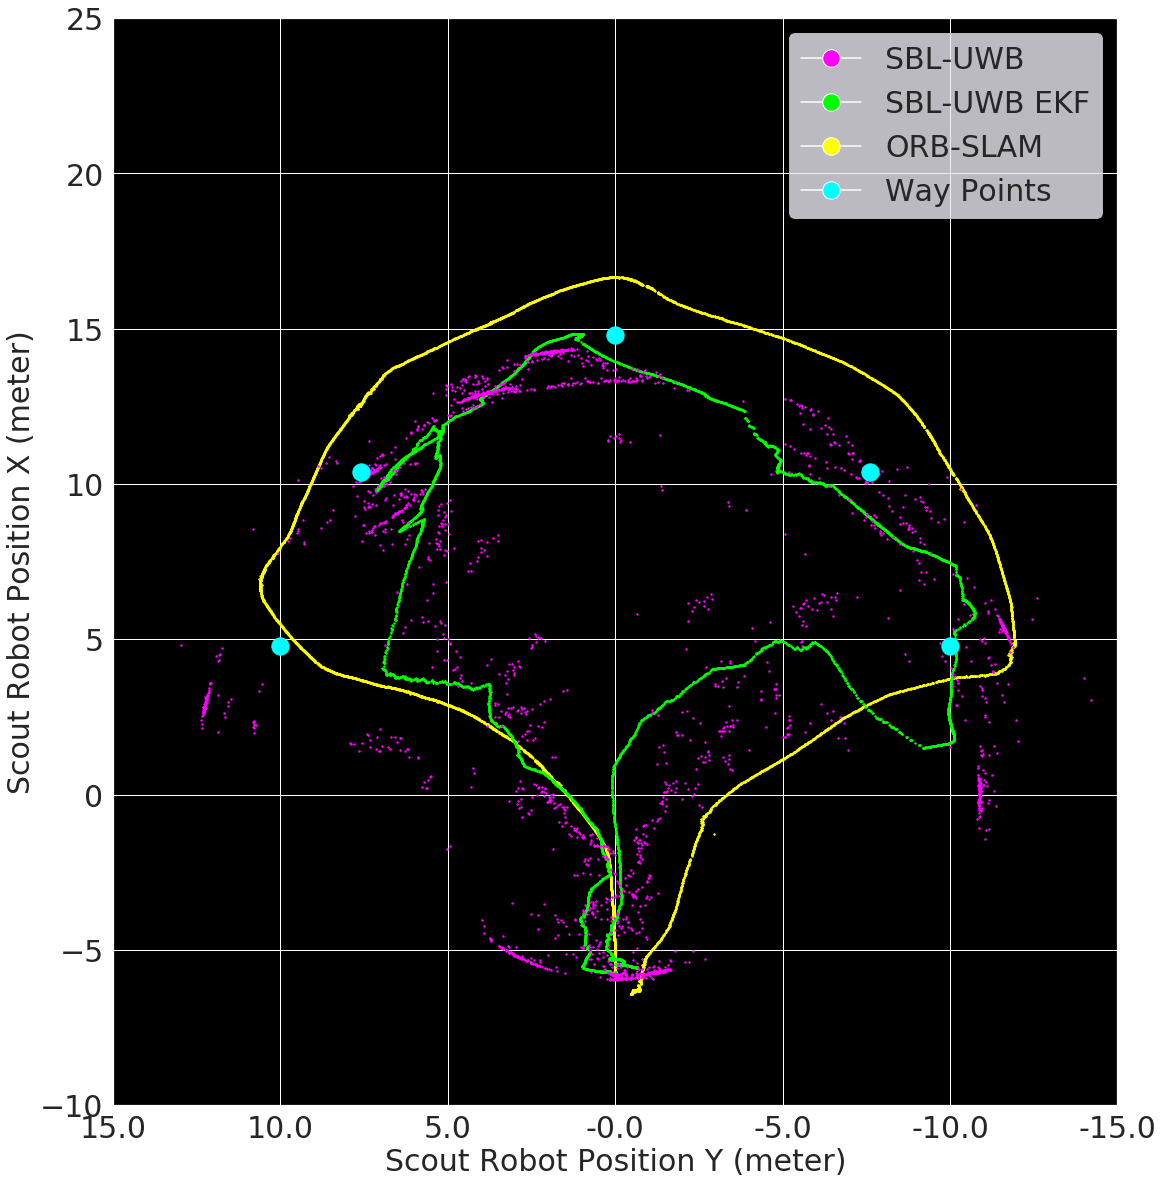

('VO Baseline: ', 2.012512016112276)
('SBL-WUB : ', 3.0773215453102054)
('VO Max: ', 2.4606793330568877)
('SBL Max: ', 5.8652807478455085)
('VO Min: ', 1.809535626143854)
('SBL Min: ', 0.7098043694946249)
('New file: ', 'range_data/exp1/locobot_allb_clockwise_vo.yaml')
('New file: ', 'range_data/exp1/husky2_allb_clockwise_sbl.yaml')


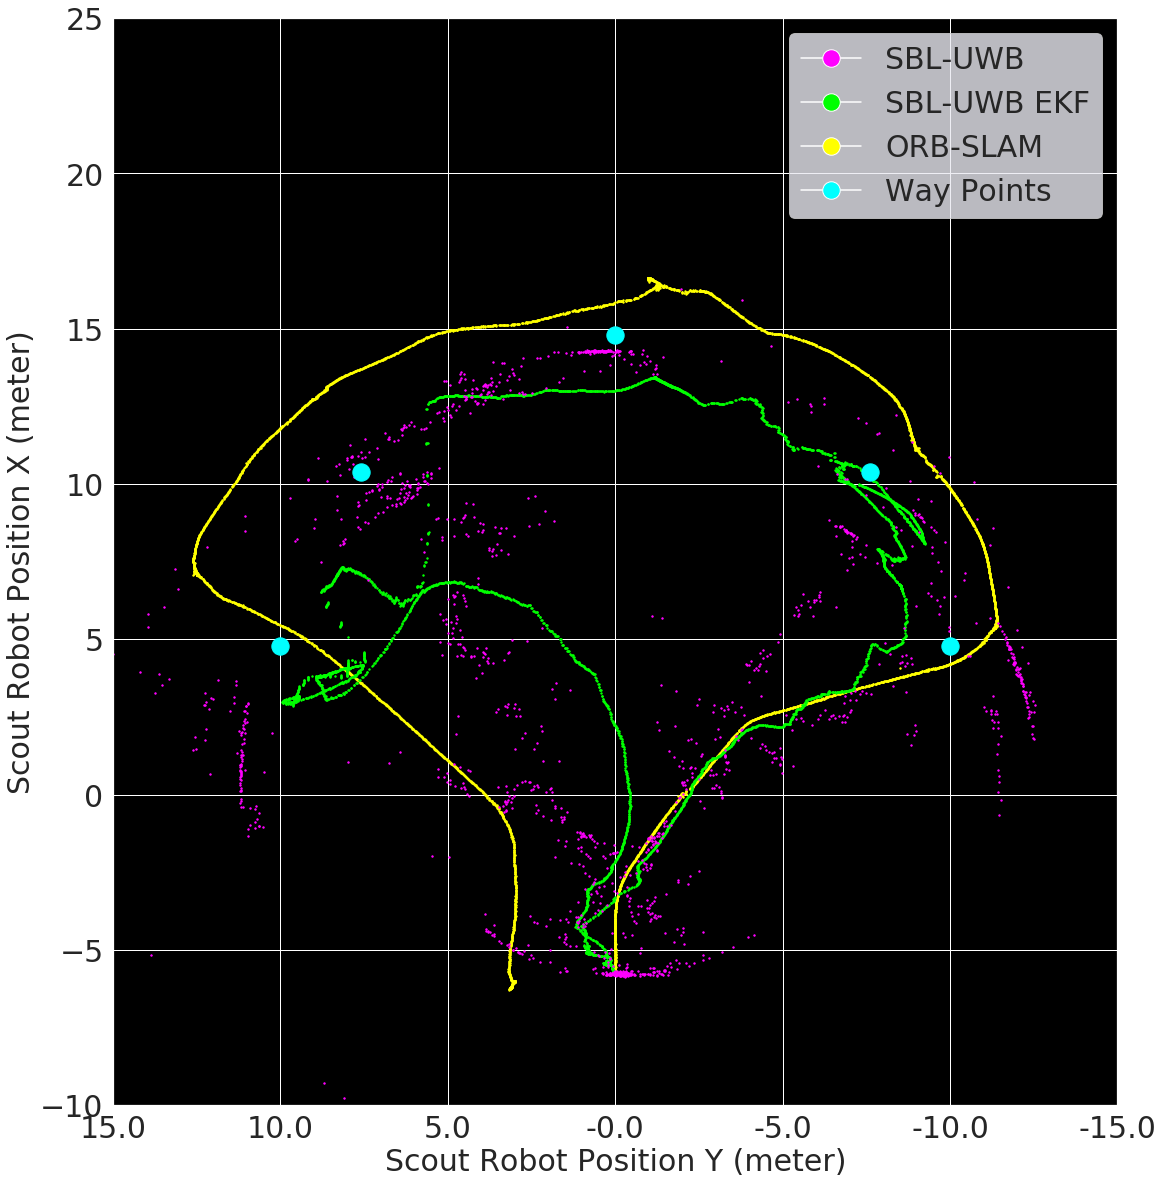

('VO Baseline: ', 2.304148024227393)
('SBL-WUB : ', 2.467247658720924)
('VO Max: ', 3.385945504683217)
('SBL Max: ', 3.714611639201733)
('VO Min: ', 1.3974625730760903)
('SBL Min: ', 0.11527047501212874)
('New file: ', 'range_data/exp1/locobot_lbrd_counter_vo.yaml')
('New file: ', 'range_data/exp1/husky2_lbrd_counter_sbl.yaml')


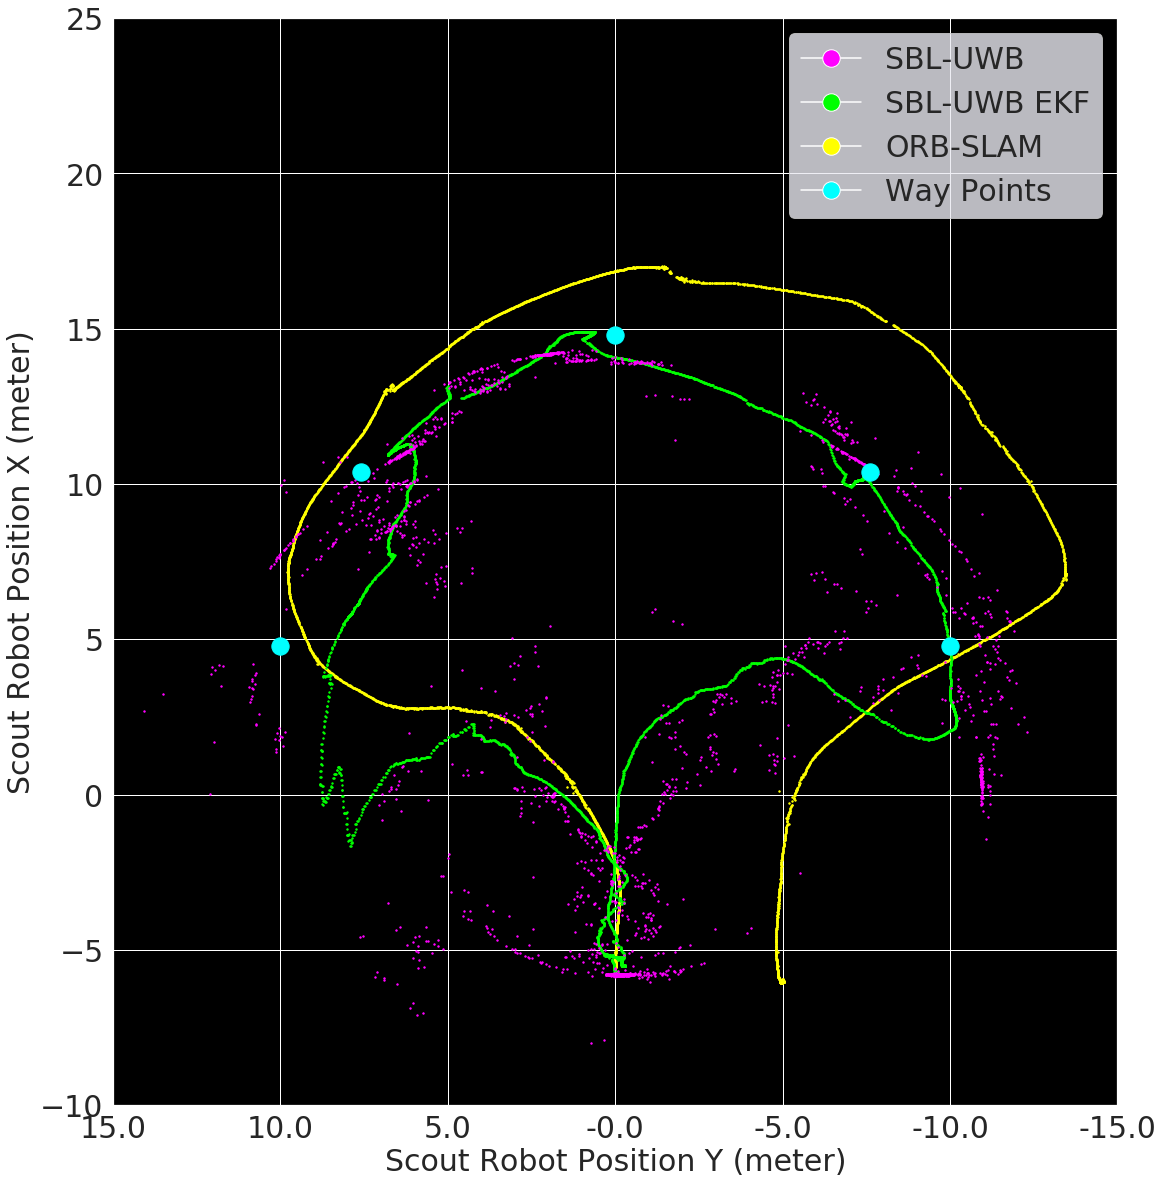

('VO Baseline: ', 3.1835463292965027)
('SBL-WUB : ', 1.9796716103033907)
('VO Max: ', 4.950423077947762)
('SBL Max: ', 4.594939272263934)
('VO Min: ', 2.3613620516649014)
('SBL Min: ', 0.23711808277837765)
('New file: ', 'range_data/exp1/locobot_lbrd_clockwise_vo.yaml')
('New file: ', 'range_data/exp1/husky2_lbrd_clockwise_sbl.yaml')


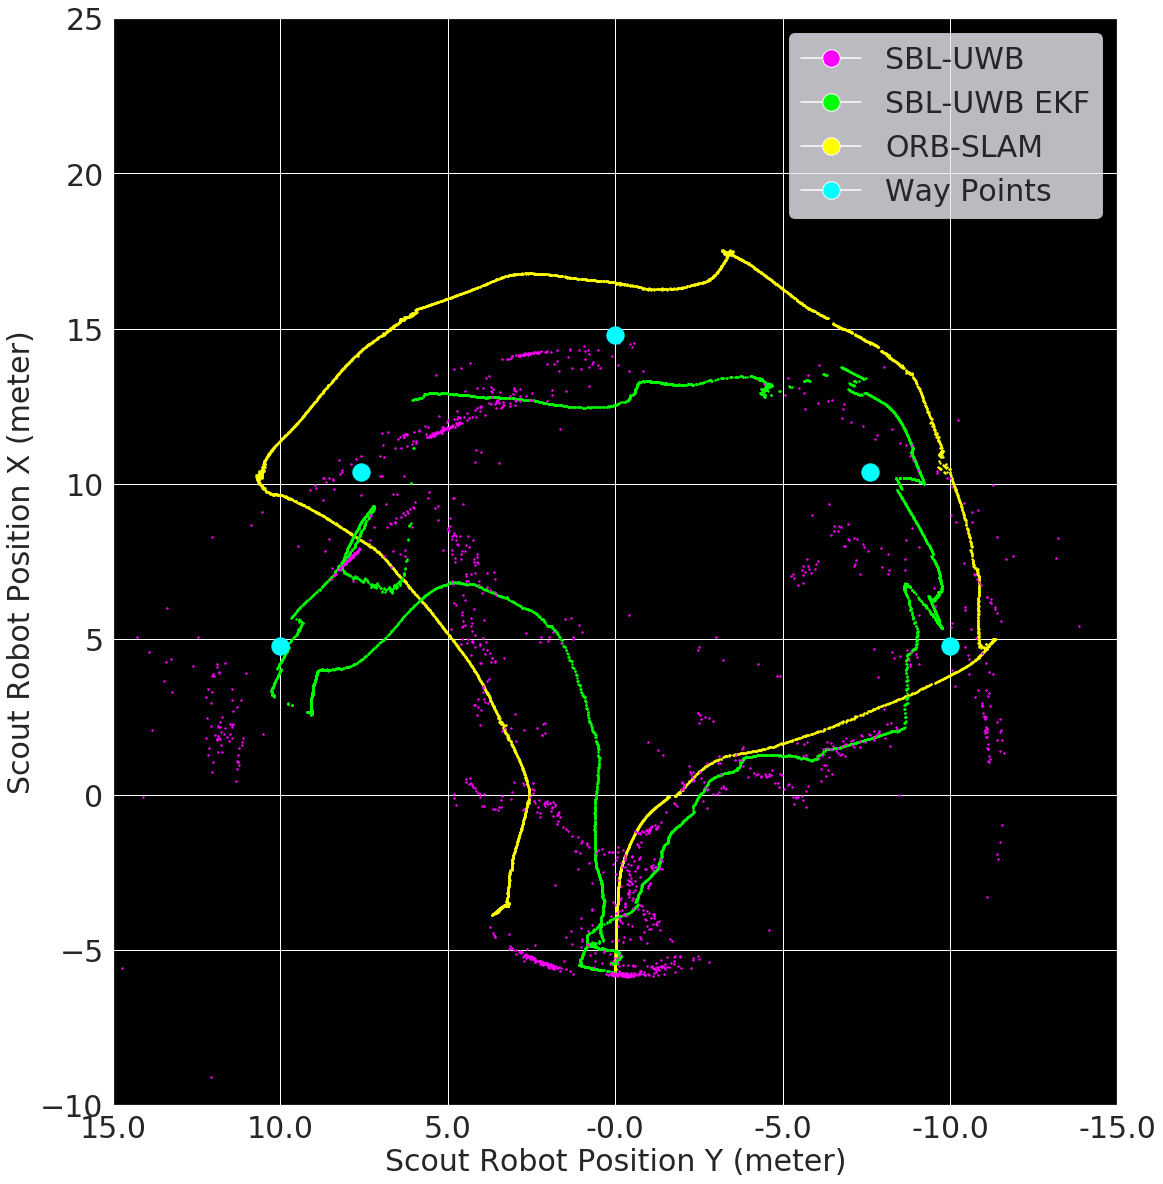

('VO Baseline: ', 4.379220442041593)
('SBL-WUB : ', 1.6896320566645655)
('VO Max: ', 5.6387255262708145)
('SBL Max: ', 2.9262270499539587)
('VO Min: ', 0.9013706362800941)
('SBL Min: ', 0.6128334233298335)
('New file: ', 'range_data/exp1/locobot_ldrb_counter_vo.yaml')
('New file: ', 'range_data/exp1/husky2_ldrb_counter_sbl.yaml')


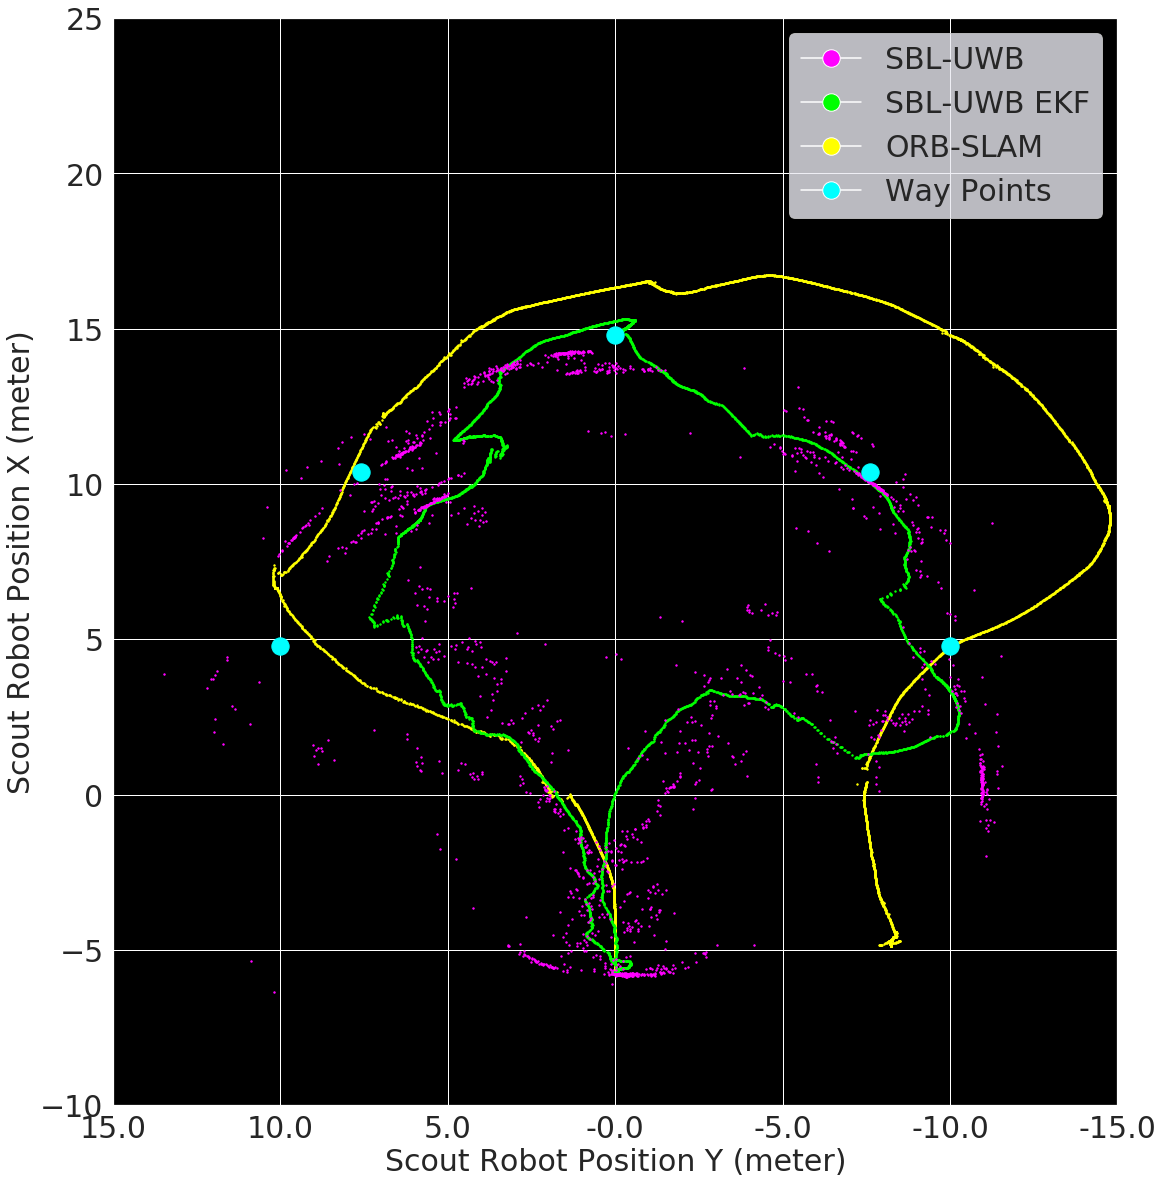

('VO Baseline: ', 4.351103966799321)
('SBL-WUB : ', 3.057259287294378)
('VO Max: ', 6.5223039092062605)
('SBL Max: ', 6.175467201598618)
('VO Min: ', 1.8409570664877069)
('SBL Min: ', 0.22031553527344122)
('New file: ', 'range_data/exp1/locobot_ldrb_clockwise_vo.yaml')
('No such file', 'range_data/exp1/locobot_ldrb_clockwise_vo.yaml')
('New file: ', 'range_data/exp1/husky2_ldrb_clockwise_sbl.yaml')
('No such file', 'range_data/exp1/wheel/locobot27_ldrb_clockwise_wheel.yaml')
('No such file', 'range_data/exp1/ldrb_clockwise.yaml')


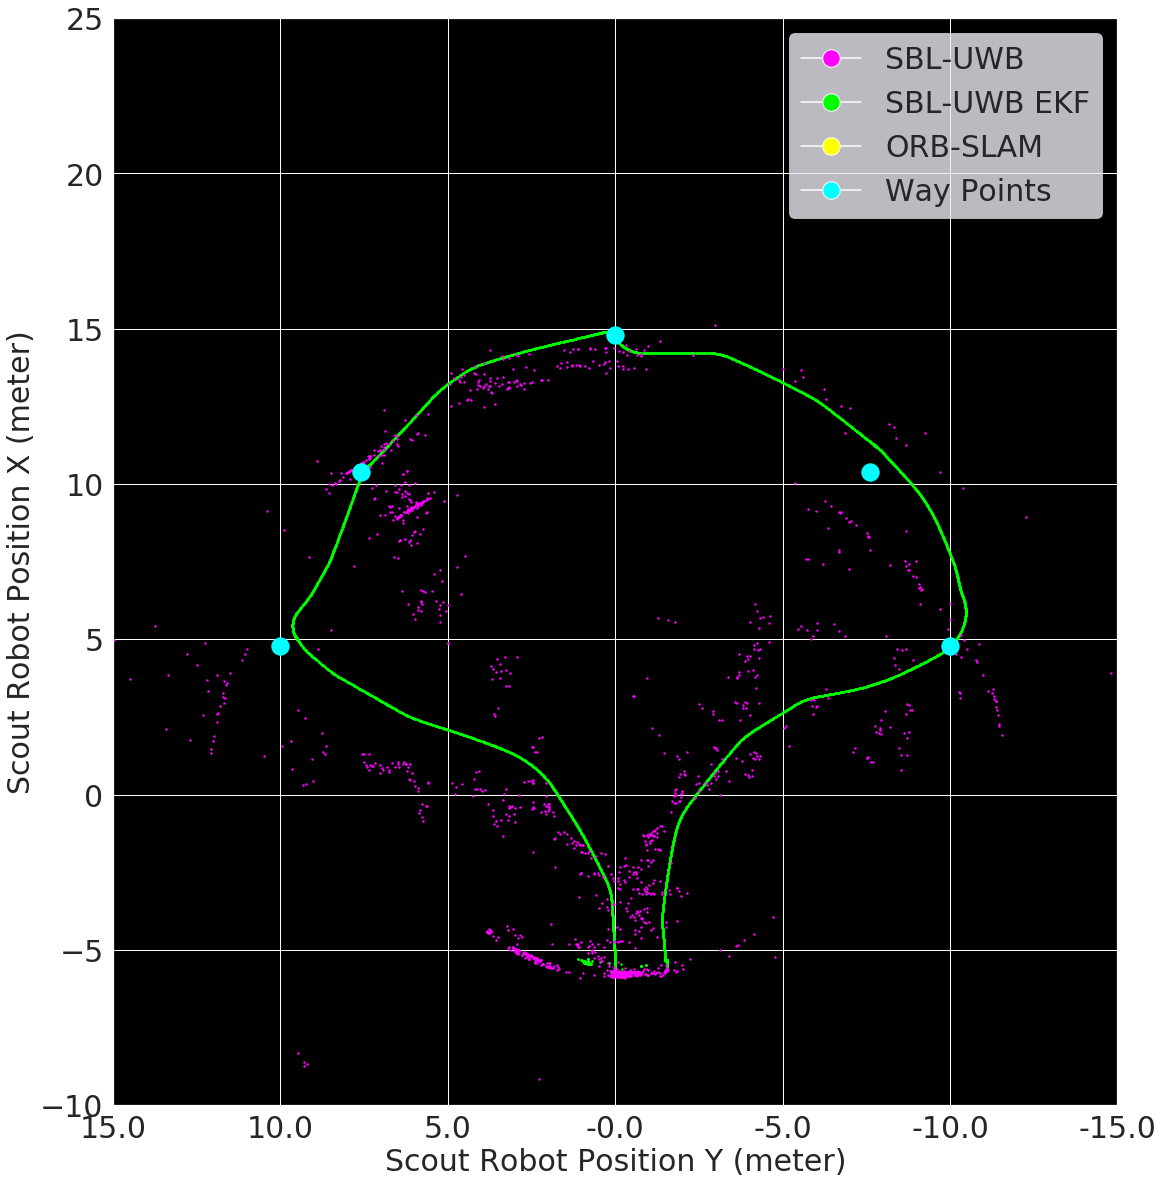

('New file: ', 'range_data/exp1/locobot_alld_counter_vo.yaml')
('New file: ', 'range_data/exp1/husky2_alld_counter_sbl.yaml')


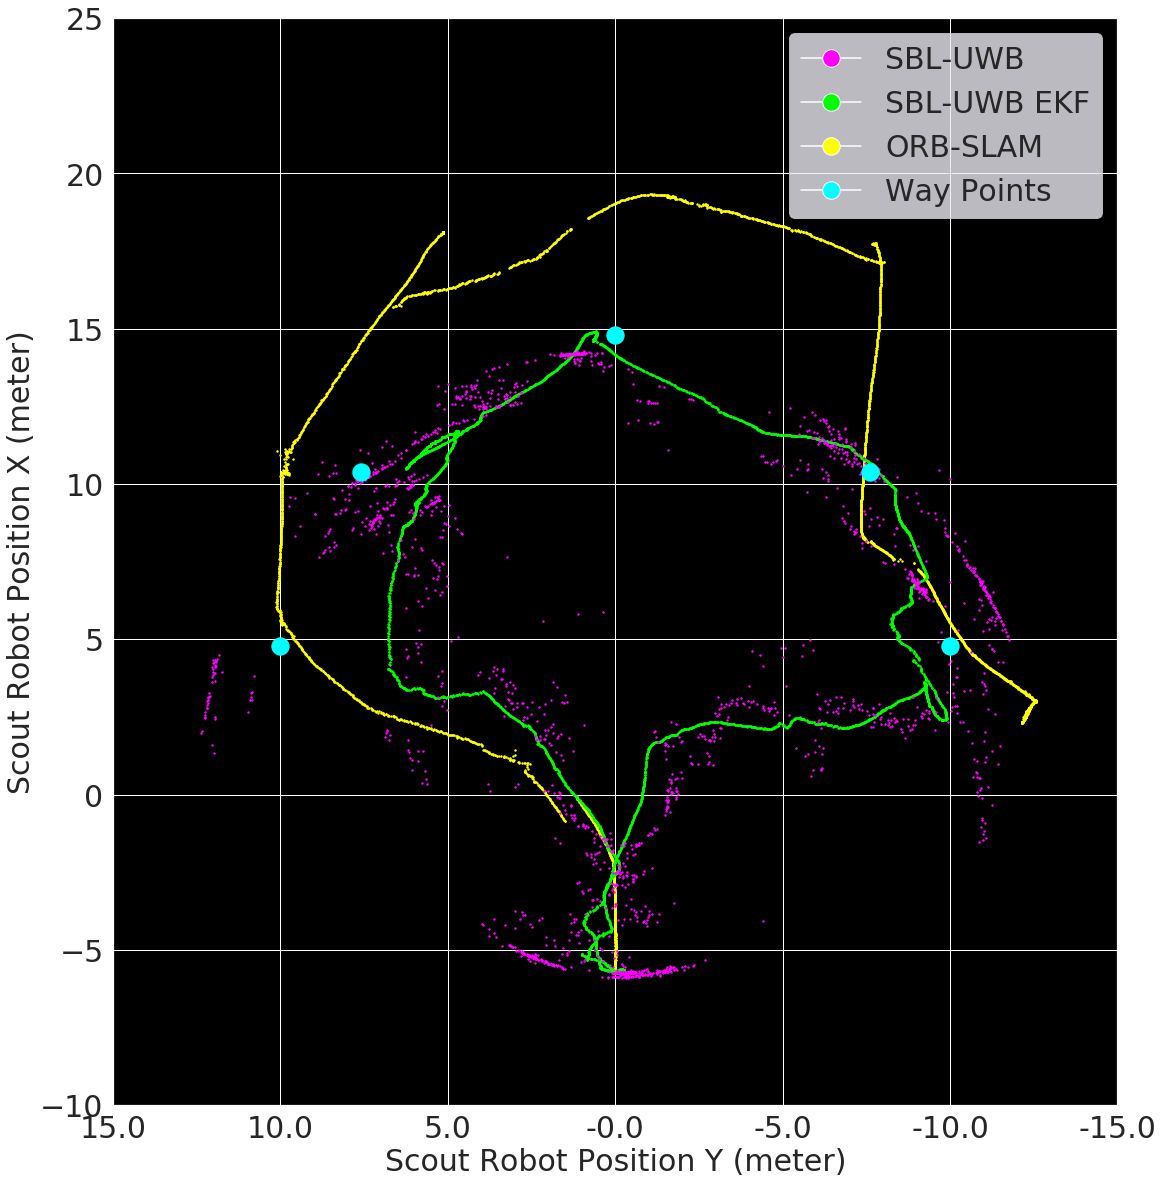

('VO Baseline: ', 7.875891302721558)
('SBL-WUB : ', 2.893141826515466)
('VO Max: ', 13.155367234163958)
('SBL Max: ', 5.9511687149907395)
('VO Min: ', 0.7048892273203028)
('SBL Min: ', 0.47985973046298624)
('New file: ', 'range_data/exp1/locobot_alld_clockwise_vo.yaml')
('New file: ', 'range_data/exp1/husky2_alld_clockwise_sbl.yaml')


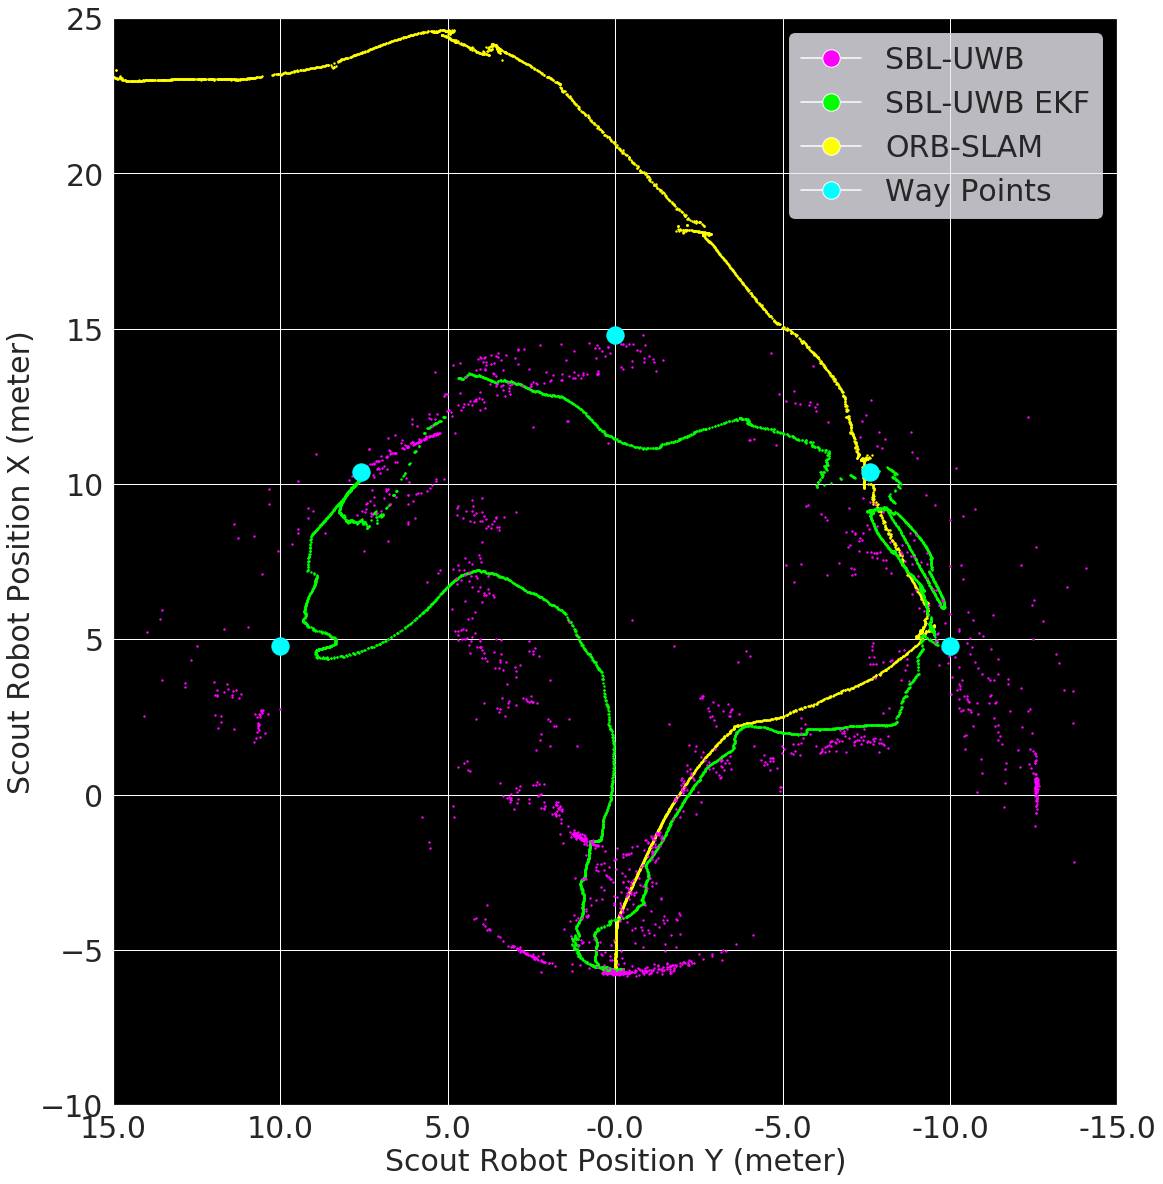

('VO Baseline: ', 11.406834149942712)
('SBL-WUB : ', 2.7647278560791517)
('VO Max: ', 20.427579918239186)
('SBL Max: ', 4.915966282102069)
('VO Min: ', 0.4003208045834653)
('SBL Min: ', 0.27424729584578666)
('Method:', 'vo')
('All Bright RMSE:', 2.162703586479335)
('All Bright Max:', 3.385945504683217)
('All Bright Min:', 1.3974625730760903)
('From B to D RMSE:', 3.1835463292965027)
('From B to D Max:', 4.950423077947762)
('From B to D Min:', 2.3613620516649014)
('From D to B RMSE:', 4.365391933115318)
('From D to B Max:', 6.5223039092062605)
('From D to B Min:', 0.9013706362800941)
('All Dark RMSE:', 9.792442224677087)
('All Dark Max:', 20.427579918239186)
('All Dark Min:', 0.4003208045834653)
('Method:', 'sbl')
('All Bright RMSE:', 2.8093906231225305)
('All Bright Max:', 5.8652807478455085)
('All Bright Min:', 0.11527047501212874)
('From B to D RMSE:', 1.9796716103033907)
('From B to D Max:', 4.594939272263934)
('From B to D Min:', 0.23711808277837765)
('From D to B RMSE:', 2.4770515

In [ ]:
env_type = ['allb', 'lbrd', 'ldrb', 'alld']
rot_type = ['counter', 'clockwise']
met_type = ['vo', 'sbl']

gt_pose = {'drill_l':[4.8, 10], 'extinguisher':[10.4, 7.6], 'survivor':[14.8, 0], 'drill_r':[4.8, -10], 'backpack':[10.4, -7.6]}
gt_pose_arr = np.array([[-5.7, 0], [4.8, 10], [10.4, 7.6], [14.8, 0], [10.4, -7.6], [4.8, -10], [-5.7, 0]])

sbl_t_offset = 12
odo_t_offset = 0

all_rmse = {}
for env in env_type:
    for rot in rot_type:
        f, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(18,20))
        rmse = {}
        max_error = {}
        min_error = {}
        for met in met_type:
            
            if met not in all_rmse:
                all_rmse[met] = {}

            if met == 'vo':
                # open files and get gt
                filename = 'range_data/exp1/locobot_' + str(env) + '_' + str(rot) + '_' + str(met) + '.yaml'
            elif met == 'sbl':
                # open files and get gt
                filename = 'range_data/exp1/husky2_' + str(env) + '_' + str(rot) + '_' + str(met) + '.yaml'

            print('New file: ',filename)
            
            # open sbl or vo
            try:
                with open(filename) as dis_file:
                    all_data = yaml.load(dis_file)
                    pos_list = all_data['data']
                    timestamp = all_data['start_time']
                    pos_list['x'] = np.array(pos_list['x'], dtype=np.float64)
                    pos_list['y'] = np.array(pos_list['y'], dtype=np.float64)
                    pos_list['timestamp'] = np.array(pos_list['timestamp'], dtype=np.float64)
                    sbl_start_t = timestamp['secs'] + timestamp['nsecs']*1e-9 + sbl_t_offset
                    del all_data
            except IOError:
                print("No such file", filename)
                continue
            
            # open wheel
            odo_filename = 'range_data/exp1/wheel/locobot27_' + str(env) + '_' + str(rot) + '_wheel.yaml'
            try:
                with open(odo_filename) as the_file:
                    all_data = yaml.load(the_file)
                    odo_pose = all_data['data']
                    odo_stamp = np.array(odo_pose['timestamp'])
                    odo_start_t = all_data['start_time']['secs'] + all_data['start_time']['nsecs']*1e-9 + odo_t_offset
                    del all_data
            except IOError:
                print("No such file", odo_filename)
            
            # open gt
            try:
                gt_time_filename = 'range_data/exp1/' + str(env) + '_' + str(rot) + '.yaml'
                with open(gt_time_filename) as gt_time_file:
                    gt_time = yaml.load(gt_time_file)
            except IOError:
                print("No such file", gt_time_filename)

            if met == 'sbl':
                t_diff = odo_start_t - sbl_start_t
                odo_stamp = odo_stamp + t_diff
                hxEst, harti_est = ekf_main(odo_pose, pos_list, odo_stamp, pos_list['timestamp'], gt_time, odo_start_t, t_diff)

                all_arti_error = np.array([])
                for arti in harti_est:
                    for p in harti_est[arti]:
                        all_arti_error = np.append(all_arti_error, (p[0]-gt_pose[arti][0])**2 + (p[1]-gt_pose[arti][1])**2) 

                rmse[met] = np.sqrt(np.mean(all_arti_error))
                max_error[met] = np.sqrt(np.max(all_arti_error))
                min_error[met] = np.sqrt(np.min(all_arti_error))
                
                if str(env)+'_'+str(rot) not in all_rmse[met]:
                    all_rmse[met][str(env)+'_'+str(rot)] = all_arti_error
                else:
                    all_rmse[met][str(env)+'_'+str(rot)] = np.append(all_rmse[met][str(env)+'_'+str(rot)],all_arti_error)

                axes.scatter(-1*hxEst[1], hxEst[0], s=2, c=color_met['ekf'])
                axes.scatter(-1*np.array(pos_list['y'], dtype=np.float64), np.array(pos_list['x'], dtype=np.float64), s=2, c=color_met['sbl'])
                #axes[0].scatter(-1*hz[1], hz[0], s=2, c=color_met['sbl'])
                axes.scatter(-1*np.array(gt_pose.values())[:,1], np.array(gt_pose.values())[:,0], s=300, c=color_met['gt'])
            elif met == 'vo':
                # start time
                start_sec = float(timestamp['secs']) + float(timestamp['nsecs'])/1e9

                # rmse calculation
                all_arti_error = []

                for arti in gt_pose:
                    st = float(gt_time[arti][0])- start_sec
                    et = float(gt_time[arti][1])- start_sec
                    si = np.argwhere(pos_list['timestamp'] >= st)[0, 0]
                    ei = np.argwhere(pos_list['timestamp'] > et)[0, 0] - 1

                    all_arti_error = np.append(all_arti_error, (pos_list['x'][si:ei+1]-gt_pose[arti][0])**2 + (pos_list['y'][si:ei+1]-gt_pose[arti][1])**2) 

                rmse[met] = np.sqrt(np.mean(all_arti_error))
                max_error[met] = np.sqrt(np.max(all_arti_error))
                min_error[met] = np.sqrt(np.min(all_arti_error))
                
                if str(env)+'_'+str(rot) not in all_rmse[met]:
                    all_rmse[met][str(env)+'_'+str(rot)] = all_arti_error
                else:
                    all_rmse[met][str(env)+'_'+str(rot)] = np.append(all_rmse[met][str(env)+'_'+str(rot)],all_arti_error)
                
                axes.scatter(-1*pos_list['y'], pos_list['x'], s=2, c=color_met[met])
        
        axes = ax_init(axes)
        plt.show()
        
        if len(rmse) >= 2:
            print("VO Baseline: ", rmse['vo'])
            print("SBL-WUB : ", rmse['sbl'])
            print("VO Max: ", max_error['vo'])
            print ("SBL Max: ", max_error['sbl'])
            print("VO Min: ", min_error['vo'])
            print ("SBL Min: ", min_error['sbl'])

        print "=================================================="

for met in met_type:
    print("Method:", met)
    allb_rmse = np.sqrt(np.mean(np.append(all_rmse[met]['allb_counter'],all_rmse[met]['allb_clockwise'])))
    allb_max = np.sqrt(np.max(np.append(all_rmse[met]['allb_counter'],all_rmse[met]['allb_clockwise'])))
    allb_min = np.sqrt(np.min(np.append(all_rmse[met]['allb_counter'],all_rmse[met]['allb_clockwise'])))
    fb2d_rmse = np.sqrt(np.mean(all_rmse[met]['lbrd_counter']))
    fb2d_max = np.sqrt(np.max(all_rmse[met]['lbrd_counter']))
    fb2d_min = np.sqrt(np.min(all_rmse[met]['lbrd_counter']))
    fd2b_rmse = np.sqrt(np.mean(np.append(all_rmse[met]['lbrd_clockwise'],all_rmse[met]['ldrb_counter'])))
    fd2b_max = np.sqrt(np.max(np.append(all_rmse[met]['lbrd_clockwise'],all_rmse[met]['ldrb_counter'])))
    fd2b_min = np.sqrt(np.min(np.append(all_rmse[met]['lbrd_clockwise'],all_rmse[met]['ldrb_counter'])))
    alld_rmse = np.sqrt(np.mean(np.append(all_rmse[met]['alld_counter'],all_rmse[met]['alld_clockwise'])))
    alld_max = np.sqrt(np.max(np.append(all_rmse[met]['alld_counter'],all_rmse[met]['alld_clockwise'])))
    alld_min = np.sqrt(np.min(np.append(all_rmse[met]['alld_counter'],all_rmse[met]['alld_clockwise'])))
    
    print("All Bright RMSE:", allb_rmse)
    print("All Bright Max:", allb_max)
    print("All Bright Min:", allb_min)
    print("From B to D RMSE:", fb2d_rmse)
    print("From B to D Max:", fb2d_max)
    print("From B to D Min:", fb2d_min)
    print("From D to B RMSE:", fd2b_rmse)
    print("From D to B Max:", fd2b_max)
    print("From D to B Min:", fd2b_min)
    print("All Dark RMSE:", alld_rmse)
    print("All Dark Max:", alld_max)
    print("All Dark Min:", alld_min)
    
    print("=====================================")